In [1]:
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler

from collections import OrderedDict

In [2]:
#timestamp_start = 50

In [3]:
# Temperature for the two consecutive timestamp
temperature_fields = []

# Folder Path
path = "solutions"
  
# Read text File  
def read_text_file(file_path):
    with h5py.File(file_path, 'r') as f:
        temperature_fields.append(f['temperature'][:])
        
        
# Iterate through all file
for file in os.listdir(path):
    file_path = f"{path}/{file}"
  
    # call read text file function
    read_text_file(file_path)
    print(f"{file_path} is finished reading")
    
temperature_fields = np.asarray(temperature_fields).reshape(10000,201,401)

solutions/solution_14.h5 is finished reading
solutions/solution_45.h5 is finished reading
solutions/solution_71.h5 is finished reading
solutions/solution_20.h5 is finished reading
solutions/solution_82.h5 is finished reading
solutions/solution_92.h5 is finished reading
solutions/solution_30.h5 is finished reading
solutions/solution_61.h5 is finished reading
solutions/solution_55.h5 is finished reading
solutions/solution_9.h5 is finished reading
solutions/solution_24.h5 is finished reading
solutions/solution_75.h5 is finished reading
solutions/solution_86.h5 is finished reading
solutions/solution_41.h5 is finished reading
solutions/solution_10.h5 is finished reading
solutions/solution_51.h5 is finished reading
solutions/solution_96.h5 is finished reading
solutions/solution_65.h5 is finished reading
solutions/solution_34.h5 is finished reading
solutions/solution_25.h5 is finished reading
solutions/solution_74.h5 is finished reading
solutions/solution_87.h5 is finished reading
solutions/s

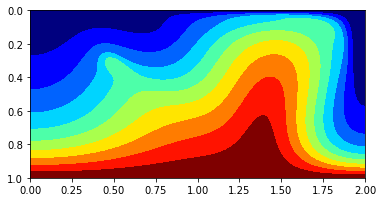

In [4]:
#print(np.asarray(temperature_fields).reshape(10000,201,401))
plt.close(1)
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.imshow(temperature_fields[6557],
          cmap=cm.get_cmap('jet', 10),
          extent=(0, 2, 0, 1))

ax.invert_yaxis()
plt.show()

In [5]:
#Parameters
n_epoch = 200
batch_size = 16
lr = 5e-5
accurate_loss_baseline = 0.005

In [6]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print("Current device is ",device)

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu


In [7]:
#print(max(np.asarray(temperature_t1).flatten()))

In [8]:
# Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self,dataset):
        # Load the data from two consecutive timestamps of temperature 
        self.data = dataset
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_item = self.data[index]
        
        return data_item

In [9]:
temperature_dataset = KMNIST(
    temperature_fields
)


generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset, validation_dataset = random_split(temperature_dataset, [0.8,0.1,0.1], generator = generator)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = batch_size,
    shuffle = False
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [10]:
train_data = next(iter(train_loader))

print(f"data batch shape: {train_data.size()}")

test_index = 0
train_data_batch_sample = train_data[test_index]

print(f"Input: {train_data_batch_sample}")

data batch shape: torch.Size([16, 201, 401])
Input: tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.9825, 0.9825, 0.9825,  ..., 0.9860, 0.9860, 0.9860],
        [0.9648, 0.9648, 0.9648,  ..., 0.9720, 0.9720, 0.9720],
        ...,
        [0.0075, 0.0069, 0.0089,  ..., 0.0042, 0.0042, 0.0042],
        [0.0038, 0.0035, 0.0045,  ..., 0.0021, 0.0021, 0.0021],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [18]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :201, :]
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential( # 201x401 => 
            nn.Conv2d(1, 3, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            #nn.BatchNorm2d(3),
            nn.Conv2d(3, 6, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            #nn.BatchNorm2d(6),
            #nn.Conv2d(6, 9, stride=(3, 3), kernel_size=(5, 5), padding=2),
            #nn.Tanh(),
            #nn.BatchNorm2d(9), 
        )
        
    def forward(self, x):
        out=self.encoder(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential( # 201x401 => 
            #nn.ConvTranspose2d(9, 6, stride=(3, 3), kernel_size=(5, 5), padding=(2,1)),
            #nn.Tanh(),
            #nn.BatchNorm2d(6),
            nn.ConvTranspose2d(6, 3, stride=(3, 3), kernel_size=(5, 5), padding=(2,2)),
            nn.Tanh(),
            #nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 1, stride=(3, 3), kernel_size=(5, 5), padding=(1,0)),
            #nn.Tanh(),
            #nn.BatchNorm2d(1),
            #Trim(),
        )
        

    def forward(self, x):
        out=self.decoder(x)
        return out

In [19]:
# pip3 install torchsummary
from torchsummary import summary
encoder = Encoder().to(device)
decoder = Decoder().to(device)
print(summary(encoder, (1, 201, 401)))
print(summary(decoder, (6, 23, 45)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 3, 67, 134]              78
              Tanh-2           [-1, 3, 67, 134]               0
            Conv2d-3            [-1, 6, 23, 45]             456
              Tanh-4            [-1, 6, 23, 45]               0
Total params: 534
Trainable params: 534
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.31
Forward/backward pass size (MB): 0.51
Params size (MB): 0.00
Estimated Total Size (MB): 0.82
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 3, 67, 133]             453
              Tanh-2           [-1, 3, 67, 133]               0
   ConvTranspose2d-3          [-1, 1, 201, 4

In [20]:
# Training Function
def train(encoder, decoder, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs= data.to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201,401)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = encoder(inputs)
            outputs = decoder(outputs)
            loss = criterion(outputs, inputs)
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        if epoch+1 == n_epoch // 4:
            print("25% of the training has finished")
                
        if epoch+1 == n_epoch // 2:
            print("50% of the training has finished")
                
        if epoch+1 == 3 * n_epoch // 4:
            print("75% of the training has finished")
            
        print(epoch+1,"epochs have finished")
        print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs = data.to(device)
                inputs = inputs.view(inputs.shape[0], 1, 201,401)
                
                # Get output features and calculate loss
                outputs = encoder(inputs)
                outputs = decoder(outputs)
                loss = criterion(outputs, inputs)
                
                # If the loss value is less than accurate loss baseline, we consider it being accurate
                for j in range(len(data)):
                    single_loss = criterion(outputs[j], inputs[j])
                    if single_loss.item() <= accurate_loss_baseline:
                        correct += 1
                    total += 1
    
                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            print("Validation loss for this epoch is",valid_loss)
            print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss
            
            # Store the best models
        
            PATH1 = 'Conv2D_encoder_best.pth'
            PATH2 = 'Conv2D_decoder_best.pth'

            torch.save(encoder.state_dict(), PATH1)
            torch.save(decoder.state_dict(), PATH2)
            print("Encoder is now saved to Path:",PATH1)
            print("Decoder is now saved to Path:",PATH2)
            
            best_model_index = epoch
            
        print()
    
    # Training finished, print the statistics for the best model
    print('Training Finished')
    print("Best model has a validation loss of {} and it's in epoch {}".format(minimum_validation_loss, best_model_index+1))
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)
    
    plt.show()

In [21]:
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=lr)

In [22]:
train(encoder, decoder, train_loader, validation_loader, device, optimizer, n_epoch)

1 epochs have finished
Current training loss is  104.87433511018753
Validation loss for this epoch is 10.083041548728943
Validation Accuracy for this epoch is 0
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

2 epochs have finished
Current training loss is  61.05958463251591
Validation loss for this epoch is 5.743046455085278
Validation Accuracy for this epoch is 0
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

3 epochs have finished
Current training loss is  35.03300365805626
Validation loss for this epoch is 3.421095736324787
Validation Accuracy for this epoch is 0
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

4 epochs have finished
Current training loss is  22.153023567050695
Validation loss for this epoch is 2.279456000775099
Validation Accuracy for this epoch is 0
Encoder is now saved to Path: Conv

Validation loss for this epoch is 0.014414250370464288
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

32 epochs have finished
Current training loss is  0.10905605515290517
Validation loss for this epoch is 0.012915548111777753
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

33 epochs have finished
Current training loss is  0.09665620108717121
Validation loss for this epoch is 0.01133310206932947
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

34 epochs have finished
Current training loss is  0.08406552972155623
Validation loss for this epoch is 0.009795998892514035
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved t

61 epochs have finished
Current training loss is  0.012144122852077999
Validation loss for this epoch is 0.0015359236022050027
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

62 epochs have finished
Current training loss is  0.011900189487278112
Validation loss for this epoch is 0.001502182611147873
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

63 epochs have finished
Current training loss is  0.01167742142934003
Validation loss for this epoch is 0.0014769029367016628
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

64 epochs have finished
Current training loss is  0.011464681709185243
Validation loss for this epoch is 0.001449714599402796
Validation Accuracy for this epoch is 100


91 epochs have finished
Current training loss is  0.00831165529871214
Validation loss for this epoch is 0.0010485843176866183
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

92 epochs have finished
Current training loss is  0.008230316442677577
Validation loss for this epoch is 0.0010402085117675597
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

93 epochs have finished
Current training loss is  0.008173837558388186
Validation loss for this epoch is 0.0010315565059499932
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

94 epochs have finished
Current training loss is  0.008106371476969798
Validation loss for this epoch is 0.0010236336493107956
Validation Accuracy for this epoch is 10

Validation loss for this epoch is 0.0008614581365691265
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

123 epochs have finished
Current training loss is  0.0067843232832274225
Validation loss for this epoch is 0.0008568140783609124
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

124 epochs have finished
Current training loss is  0.006759073666216864
Validation loss for this epoch is 0.0008543308631487889
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

125 epochs have finished
Current training loss is  0.006717529342950002
Validation loss for this epoch is 0.0008463472586299758
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is

155 epochs have finished
Current training loss is  0.00602366173734481
Validation loss for this epoch is 0.0007564759239357954
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

156 epochs have finished
Current training loss is  0.005996179996145656
Validation loss for this epoch is 0.0007543004039689549
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

157 epochs have finished
Current training loss is  0.005988130149034987
Validation loss for this epoch is 0.0007538711688539479
Validation Accuracy for this epoch is 100
Encoder is now saved to Path: Conv2D_encoder_best.pth
Decoder is now saved to Path: Conv2D_decoder_best.pth

158 epochs have finished
Current training loss is  0.005967760691873991
Validation loss for this epoch is 0.0007557499552603986
Validation Accuracy for this epoch i

KeyboardInterrupt: 

In [30]:
def test(encoder, decoder, test_loader, device, color_regions):
    encoder.load_state_dict(torch.load('Conv2D_encoder_best.pth'))
    decoder.load_state_dict(torch.load('Conv2D_decoder_best.pth'))
    
    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs = data.to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201,401)
                
            # Get output features and calculate loss
            outputs = encoder(inputs)
            outputs = decoder(outputs)
            loss = criterion(outputs, inputs)
                
            # If the loss value is less than 0.01, we consider it being accurate
            for j in range(len(inputs)):
                single_loss = criterion(outputs[j], inputs[j])
                if single_loss.item() <= accurate_loss_baseline:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    #print(max(best_worst_input_list[0].detach().numpy()[0].flatten()))
    #print(max(best_worst_predicted_list[0].detach().numpy()[0].flatten()))
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_input_list[0].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_input_list[0].detach().numpy()[0],
                  extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_predicted_list[0].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_predicted_list[0].detach().numpy()[0],
                  extent=(0, 2, 0, 1))
        
    ax.invert_yaxis()
    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    #print(max(best_worst_input_list[1].detach().numpy()[0].flatten()))
    #print(max(best_worst_predicted_list[1].detach().numpy()[0].flatten()))
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_input_list[1].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_input_list[1].detach().numpy()[0],
                  extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_predicted_list[1].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_predicted_list[1].detach().numpy()[0],
                  extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()

Total loss for the model is 0.0056219100183625415
Accuracy for the model is 100

Best model has a error of  2.222201374024735e-06


<ipython-input-30-d7d3e52fcf0f>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


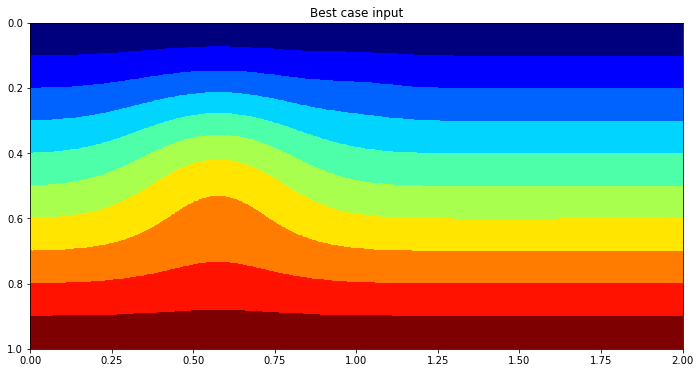

<ipython-input-30-d7d3e52fcf0f>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


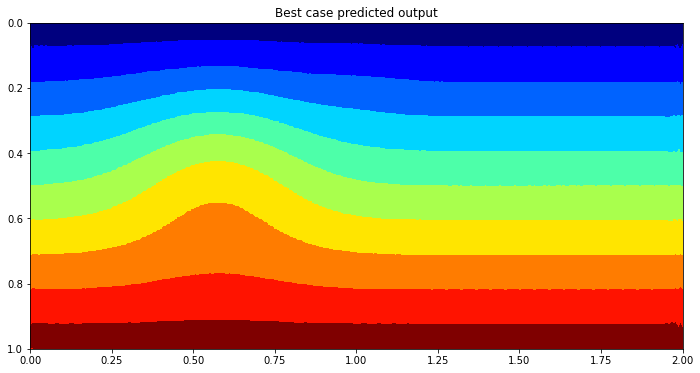

<ipython-input-30-d7d3e52fcf0f>:99: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


Worst model has a error of  0.0001394763821735978


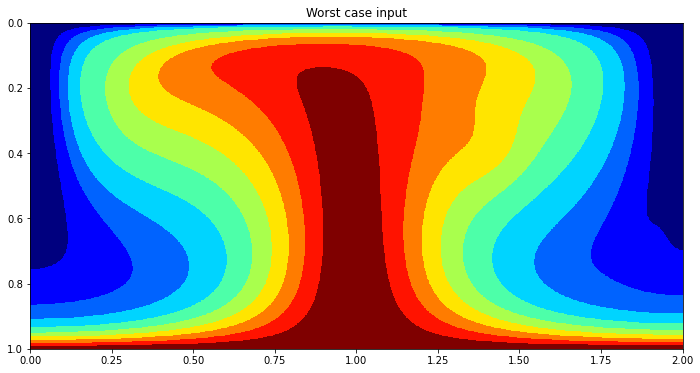

<ipython-input-30-d7d3e52fcf0f>:115: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


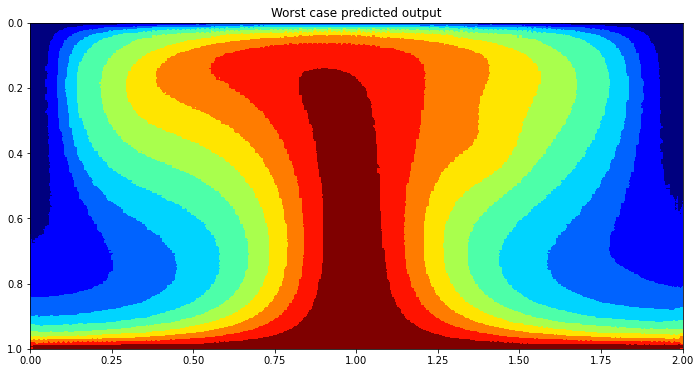

In [31]:
# Test for training set, with 10 color regions
test(encoder, decoder, train_loader, device, 1)

Total loss for the model is 0.005621910010177089
Accuracy for the model is 100

Best model has a error of  2.222201374024735e-06


<ipython-input-30-d7d3e52fcf0f>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


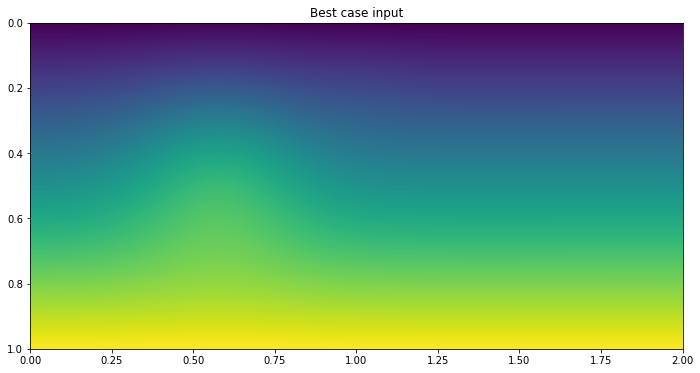

<ipython-input-30-d7d3e52fcf0f>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


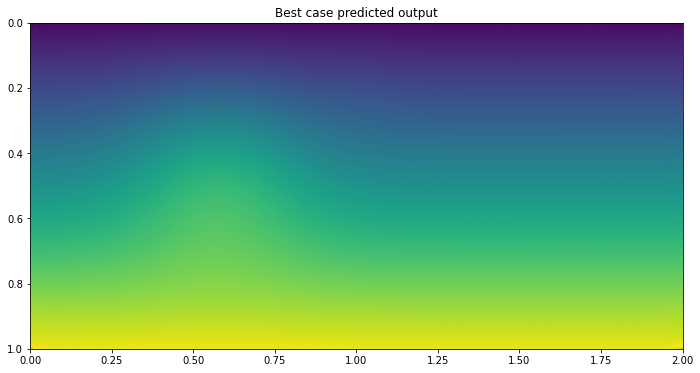

Worst model has a error of  0.0001394763821735978


<ipython-input-30-d7d3e52fcf0f>:99: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


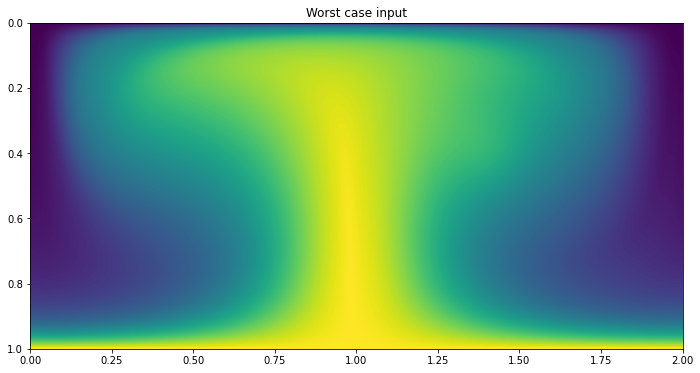

<ipython-input-30-d7d3e52fcf0f>:115: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


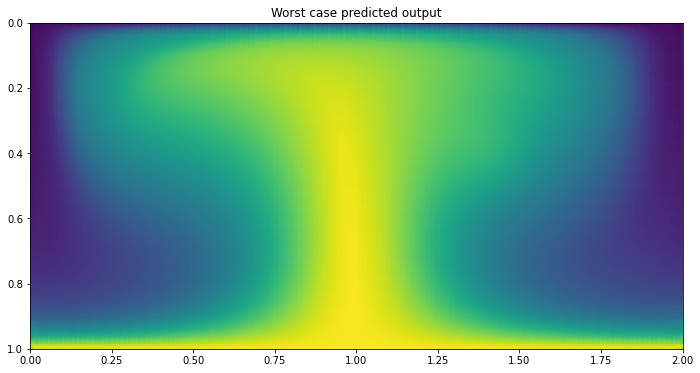

In [32]:
# Test for training set, without color regions
test(encoder, decoder, train_loader, device, 0)

Total loss for the model is 0.00069647429518227
Accuracy for the model is 100

Best model has a error of  2.2441074634116376e-06


<ipython-input-30-d7d3e52fcf0f>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


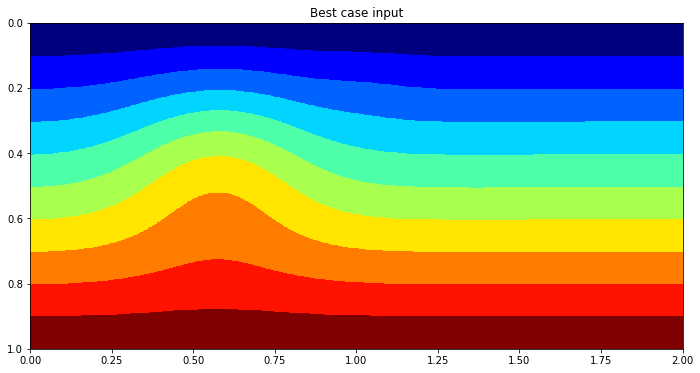

<ipython-input-30-d7d3e52fcf0f>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


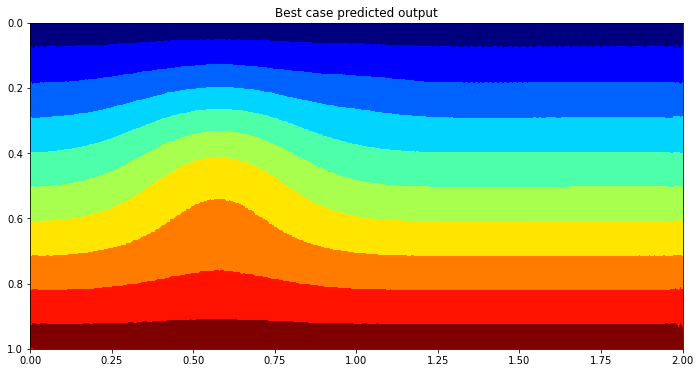

<ipython-input-30-d7d3e52fcf0f>:99: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


Worst model has a error of  0.00012063430767739192


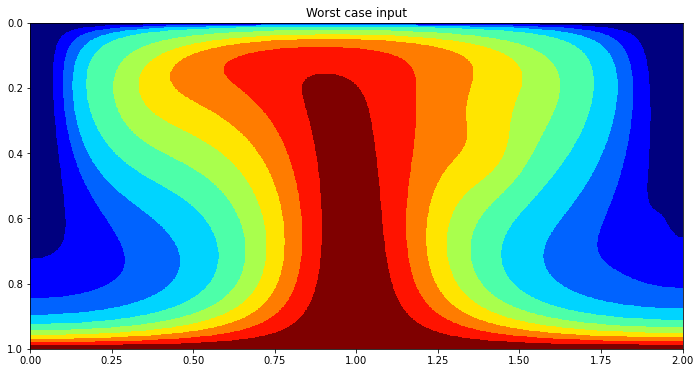

<ipython-input-30-d7d3e52fcf0f>:115: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


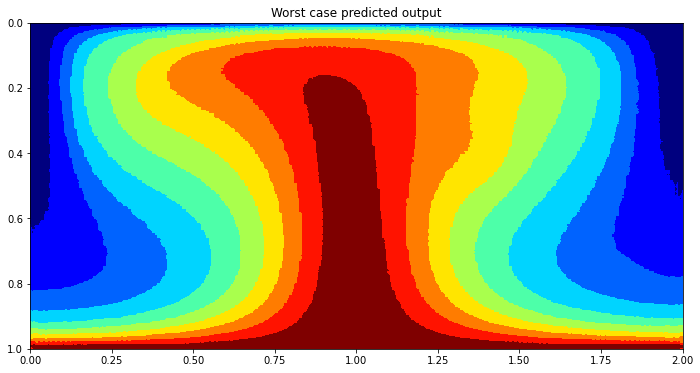

In [33]:
# Test for testing set, with 10 color regions
test(encoder, decoder, test_loader, device, 1)

Total loss for the model is 0.00069647429518227
Accuracy for the model is 100

Best model has a error of  2.2441074634116376e-06


<ipython-input-30-d7d3e52fcf0f>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


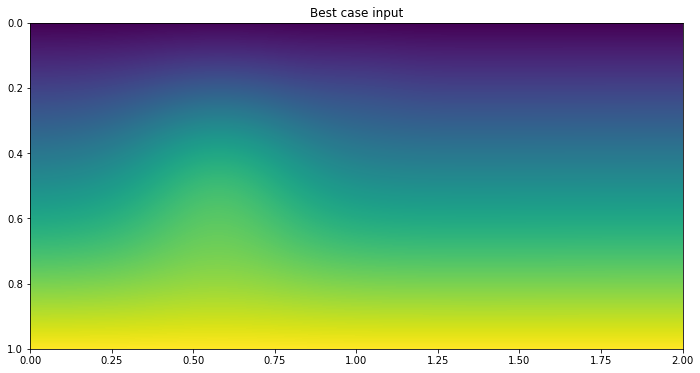

<ipython-input-30-d7d3e52fcf0f>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


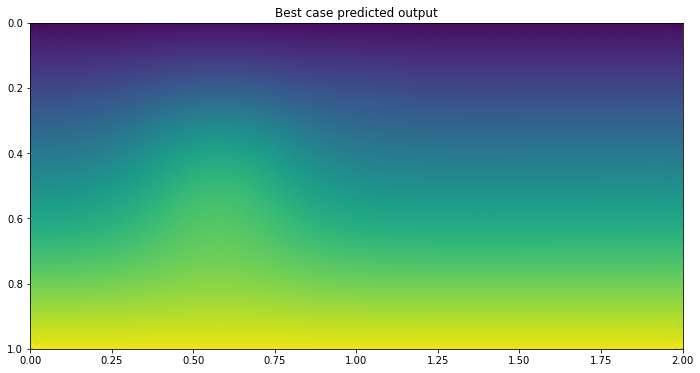

Worst model has a error of  0.00012063430767739192


<ipython-input-30-d7d3e52fcf0f>:99: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


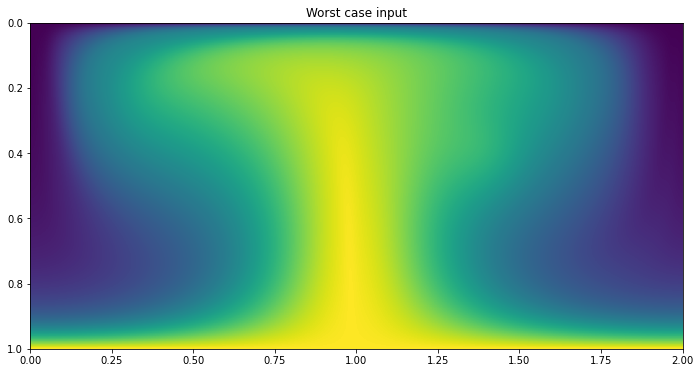

<ipython-input-30-d7d3e52fcf0f>:115: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


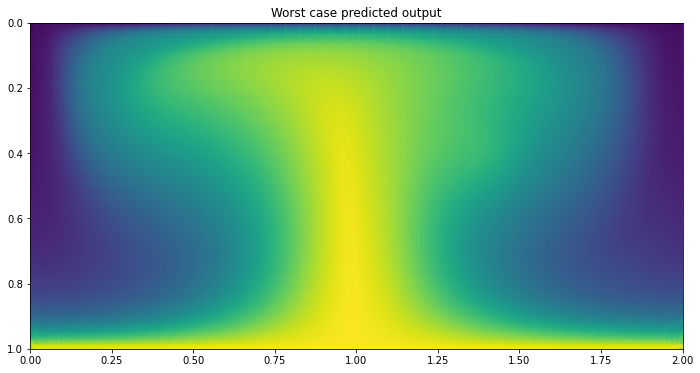

In [34]:
# Test for testing set, without color regions
test(encoder, decoder, test_loader, device, 0)